<a href="https://colab.research.google.com/github/livjab/DS3-Kaggle-Comptetion/blob/master/Kaggle_challenge_(cleaned_up_notebook).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

In [136]:
test = pd.read_csv("https://raw.githubusercontent.com/livjab/DS3-Kaggle-Comptetion/master/test_features.csv")
train = pd.read_csv("https://raw.githubusercontent.com/livjab/DS3-Kaggle-Comptetion/master/train_features.csv")
train_y = pd.read_csv("https://raw.githubusercontent.com/livjab/DS3-Kaggle-Comptetion/master/train_labels.csv")

train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [137]:
# fast first baseline

train_y["status_group"].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [138]:
# going to combine train_y with train for ease

train = pd.merge(train, train_y)
train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
def clean(df):
  
  # separating date into year/month/day
  df["date_recorded_sep"] = train["date_recorded"].str.split("-")
  
  # create new features for each
  df["year_recorded"] = pd.to_numeric(df["date_recorded_sep"].str[0])
  df["month_recorded"] = pd.to_numeric(df["date_recorded_sep"].str[1])
  df["day_of_month_recorded"] = pd.to_numeric(df["date_recorded_sep"].str[2])
  
  # drop separated column
  df = df.drop(columns="date_recorded_sep")
  
  
  # changing public_meeting to 0/1
  df["public_meeting"] = df.public_meeting.fillna(value="True")
  df["public_meeting"] = df.public_meeting.astype(bool).astype(int)
  
  # changing permit to 0/1
  df["permit"] = df.permit.fillna(value="True")
  df["permit"] = df.permit.astype(bool).astype(int)
  
  
  # drop the following features due to repetition and/or insignificance
  df = df.drop(columns=["id", # random number
                        "recorded_by", # same entry in every row
                        "extraction_type", # basically a duplicate
                        "extraction_type_group", # another near duplicate
                        "payment", # has a near duplicate
                        "water_quality", # has a near duplicate
                        "quantity_group", # has an exact duplicate
                        "source_type", # heas a near duplicate
                        "waterpoint_type_group"]) # has a near duplicate
  
  # feature engineering
  
  # create age
  df["age_of_pump"] = df["year_recorded"] - df["construction_year"]
  
  # water per person
  #df["water_per_person"] = df["amount_tsh"] / df["population"]
  

  return df

In [0]:
train.dtypes

In [139]:
train = clean(train)
X_train = train.drop(columns="status_group")
y_train = train["status_group"]
X_train.head()


,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type_class,management,management_group,payment_type,quality_group,quantity,source,source_class,waterpoint_type,year_recorded,month_recorded,day_of_month_recorded,age of pump
0,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,1,VWC,Roman,0,1999,gravity,vwc,user-group,annually,good,enough,spring,groundwater,communal standpipe,2011,3,14,12
1,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,1,Other,NaN,1,2010,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,2013,3,6,3
2,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,1,VWC,Nyumba ya mungu pipe scheme,1,2009,gravity,vwc,user-group,per bucket,good,enough,dam,surface,communal standpipe multiple,2013,2,25,4
3,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,1,VWC,NaN,1,1986,submersible,vwc,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,2013,1,28,27
4,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,1,NaN,NaN,1,0,gravity,other,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,2011,7,13,2011


In [140]:
X_test = clean(test)
X_test.shape, X_train.shape

((14358, 35), (59400, 35))

In [63]:
train.isnull().sum().sort_values(ascending=False).head(10)

scheme_name              28166
scheme_management         3877
installer                 3655
funder                    3635
subvillage                 371
day_of_month_recorded        0
basin                        0
district_code                0
region_code                  0
region                       0
dtype: int64

In [102]:
numeric_columns = train.select_dtypes(include="number").columns
numeric_columns.tolist()

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'public_meeting',
 'permit',
 'construction_year',
 'year_recorded',
 'month_recorded',
 'day_of_month_recorded',
 'age of pump']

In [103]:
categorical_columns = train.select_dtypes(exclude="number").columns
categorical_columns = categorical_columns.drop("status_group")
categorical_columns.tolist()

['date_recorded',
 'funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'scheme_management',
 'scheme_name',
 'extraction_type_class',
 'management',
 'management_group',
 'payment_type',
 'quality_group',
 'quantity',
 'source',
 'source_class',
 'waterpoint_type']

In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

np.random.seed(0)


# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = numeric_columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = categorical_columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='lbfgs'))])

X = train.drop('status_group', axis=1)
y = train['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


model score: 0.782


In [55]:
from sklearn.ensemble import RandomForestClassifier

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = numeric_columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = categorical_columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(max_depth=8))])

X = train.drop('status_group', axis=1)
y = train['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


model score: 0.565


In [56]:
from xgboost import XGBClassifier

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = numeric_columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = categorical_columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(max_depth=8))])

X = train.drop('status_group', axis=1)
y = train['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.786


In [0]:
# going to make another submission since this has beat my other scores

y_pred = clf.predict(test)

sample_submission = pd.read_csv('https://raw.githubusercontent.com/livjab/DS3-Kaggle-Comptetion/master/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred

from google.colab import files
submission.to_csv('LJ-fourth-submission.csv', index=False)
files.download('LJ-fourth-submission.csv')

In [60]:
!pip install category_encoders

In [112]:
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = numeric_columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = categorical_columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', ce.OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(max_depth=7))])

X = train.drop('status_group', axis=1)
y = train['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))


model score: 0.779


In [0]:
# slowly bumping up, going to submit this score as well

y_pred = clf.predict(test)

sample_submission = pd.read_csv('https://raw.githubusercontent.com/livjab/DS3-Kaggle-Comptetion/master/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred

from google.colab import files
submission.to_csv('LJ-fifth-submission.csv', index=False)
files.download('LJ-fifth-submission.csv')

In [104]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

preprocessor = make_pipeline(ce.OrdinalEncoder(), 
                             StandardScaler(), 
                             SimpleImputer())

features = train.drop(columns="status_group")
target = "status_group"

X_train = preprocessor.fit_transform(features)
X_test = preprocessor.transform(features)

X_train = pd.DataFrame(X_train)
y_train = train[target]

from sklearn.model_selection import cross_validate

scores = cross_validate(XGBClassifier(max_depth=5, n_estimators=100), 
                        X_train, 
                        y_train, 
                        scoring="accuracy",
                        cv=3, 
                        return_train_score=True, 
                        return_estimator=True)
pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,27.081130,0.387643,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.772172,0.789091
1,26.935004,0.392727,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.773636,0.789217
2,26.912828,0.359417,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.734394,0.790278


In [0]:
!pip install xgboost --upgrade

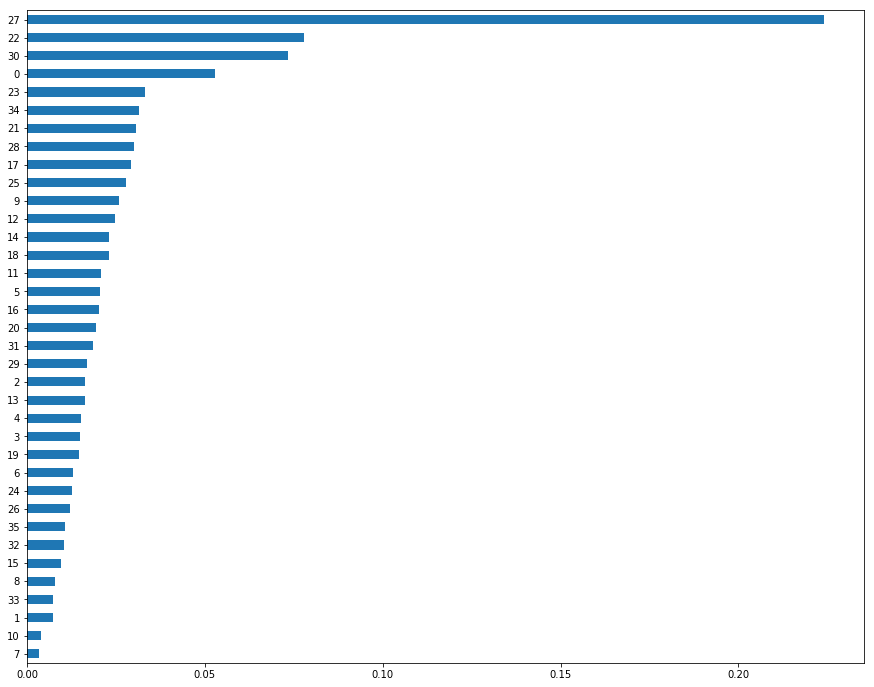

In [87]:
import matplotlib.pyplot as plt

importances = pd.Series(boost.feature_importances_, X_train.columns)
top_n = importances.sort_values(ascending=True)
plt.figure(figsize=(15,12))
top_n.plot.barh();

In [141]:
numeric_columns = train.select_dtypes(include="number").columns
numeric_columns.tolist()

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'public_meeting',
 'permit',
 'construction_year',
 'year_recorded',
 'month_recorded',
 'day_of_month_recorded',
 'age of pump']

In [145]:
features = numeric_columns
target = "status_group"

X_train = train[features]
y_train = train[target]
X_test = X_test[features]

scores = cross_validate(XGBClassifier(max_depth=6, n_estimators=100),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,16.611366,0.447846,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.691111,0.716742
1,17.131133,0.452237,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.688131,0.717323
2,16.709085,0.451694,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.679697,0.714949


In [0]:
boost = XGBClassifier(max_depth=6, n_estimators=100)
boost.fit(X_train, y_train)

y_pred = boost.predict(X_test)

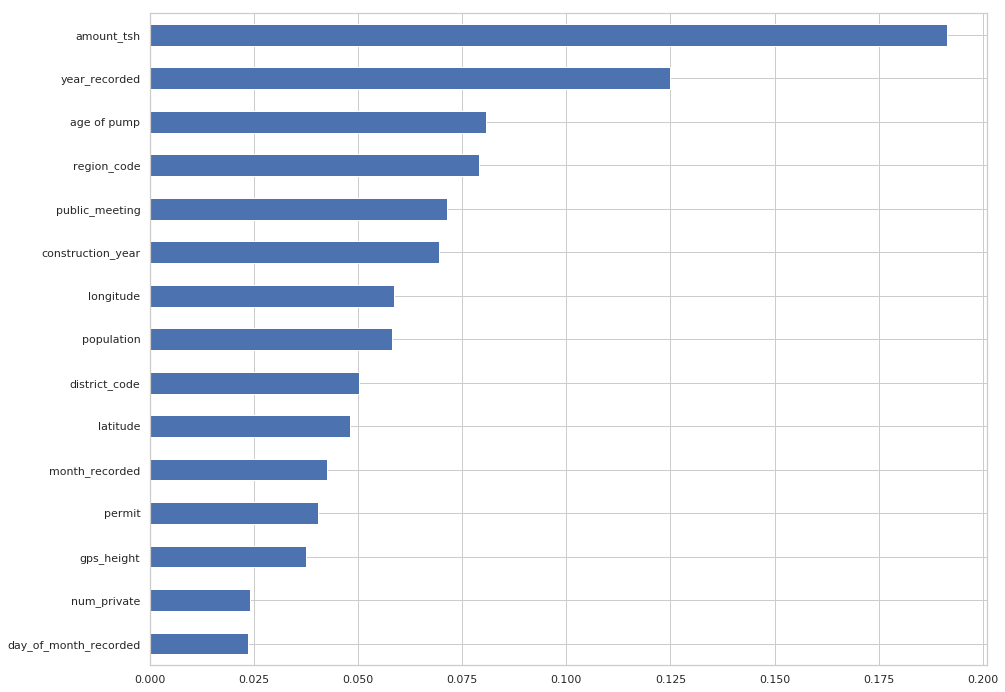

In [147]:
import matplotlib.pyplot as plt

importances = pd.Series(boost.feature_importances_, X_train.columns)
top_n = importances.sort_values(ascending=True)
plt.figure(figsize=(15,12))
top_n.plot.barh();

In [159]:
# just going to continue to iterate on my best model and play areound with feature selection

numeric_features = ["amount_tsh", "year_recorded", "age of pump", "public_meeting", "construction_year"]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ["basin", "source_class", "quantity"]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(max_depth=8))])

X = train.drop('status_group', axis=1)
y = train['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.715


In [160]:
numeric_features = ["amount_tsh", "year_recorded", "age of pump", "public_meeting", "construction_year"]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ["basin", "source_class", "quantity", "source", "region"]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(max_depth=7))])

X = train.drop('status_group', axis=1)
y = train['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.724


In [163]:
numeric_features = ["amount_tsh", "year_recorded", "age of pump", "public_meeting", "construction_year"]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ["basin", "source_class", "quantity", "source", "region", "waterpoint_type"]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(max_depth=7))])

X = train.drop('status_group', axis=1)
y = train['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.759


In [162]:
categorical_columns

Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'scheme_management',
       'scheme_name', 'extraction_type_class', 'management',
       'management_group', 'payment_type', 'quality_group', 'quantity',
       'source', 'source_class', 'waterpoint_type'],
      dtype='object')

In [165]:
numeric_features = ["amount_tsh", "year_recorded", "age of pump", "public_meeting", "construction_year"]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ["basin", "source_class", "quantity", "source", "region", "waterpoint_type", "quality_group", "extraction_type_class"]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(max_depth=7))])

X = train.drop('status_group', axis=1)
y = train['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.762


In [0]:
numeric_features = ["amount_tsh", "year_recorded", "age of pump", "public_meeting", "construction_year"]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ["basin", "source_class", "quantity", "source", "region", "waterpoint_type", "quality_group", "extraction_type_class"]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', ce.OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(max_depth=8))])

X = train.drop('status_group', axis=1)
y = train['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))


model score: 0.768


In [168]:
numeric_features = ["amount_tsh", "year_recorded", "age of pump", "public_meeting", "construction_year"]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'scheme_management',
       'scheme_name', 'extraction_type_class', 'management',
       'management_group', 'payment_type', 'quality_group', 'quantity',
       'source', 'source_class', 'waterpoint_type']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', ce.OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(max_depth=8))])

X = train.drop('status_group', axis=1)
y = train['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))


model score: 0.784
